In [52]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph langchain langchain-community

In [53]:
from typing import Dict, TypedDict, List, Optional, Literal, Any
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image

In [54]:
import os
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

## State

In [55]:
class State(TypedDict):
    query: str
    category: Optional[str]
    sentiment: Optional[str]
    response: Optional[str]
    conversation_history: List[Dict[str, str]]

## Node functions

In [56]:
def categorize(state: State) -> Dict:
    """Categorize the customer query into Technical, Billing, or General."""
    if not state["query"]:
        return {"category": "General"}
        
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}\n\n"
        "Reply with just the category name."
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY)  
    category = chain.invoke({"query": state["query"]}).content.strip()
    return {"category": category}

def analyze_sentiment(state: State) -> Dict:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    if not state["query"]:
        return {"sentiment": "Neutral"}
        
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with only one word - either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY)  
    sentiment = chain.invoke({"query": state["query"]}).content.strip()
    return {"sentiment": sentiment}

def handle_technical(state: State) -> Dict:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "You are a helpful technical support agent. "
        "Consider the following conversation history for context: {conversation_history}\n\n"
        "Provide a detailed technical support response to the latest query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY) 
    response = chain.invoke({
        "query": state["query"],
        "conversation_history": format_conversation_history(state["conversation_history"])
    }).content
    return {"response": response}

def handle_billing(state: State) -> Dict:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "You are a helpful billing support agent. "
        "Consider the following conversation history for context: {conversation_history}\n\n"
        "Provide a detailed billing support response to the latest query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY)  
    response = chain.invoke({
        "query": state["query"],
        "conversation_history": format_conversation_history(state["conversation_history"])
    }).content
    return {"response": response}

def handle_general(state: State) -> Dict:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "You are a helpful customer support agent. "
        "Consider the following conversation history for context: {conversation_history}\n\n"
        "Provide a detailed general support response to the latest query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY) 
    response = chain.invoke({
        "query": state["query"],
        "conversation_history": format_conversation_history(state["conversation_history"])
    }).content
    return {"response": response}

def escalate(state: State) -> Dict:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment. A member of our team will contact you shortly."}

def update_conversation_history(state: State) -> Dict:
    """Update the conversation history with the latest query and response."""
    conversation_history = state.get("conversation_history", []).copy()
    if state["query"]:  # Only add non-empty queries to history
        conversation_history.append({
            "query": state["query"],
            "category": state.get("category", "Unknown"),
            "sentiment": state.get("sentiment", "Unknown"),
            "response": state.get("response", "")
        })
    return {"conversation_history": conversation_history}

def format_conversation_history(history: List[Dict[str, str]]) -> str:
    """Format the conversation history for inclusion in prompts."""
    if not history:
        return "No previous conversation."
    
    formatted = []
    for i, entry in enumerate(history[-3:]):  # Only use the most recent 3 exchanges
        formatted.append(f"Turn {i+1}:")
        formatted.append(f"User: {entry.get('query', '')}")
        formatted.append(f"Agent ({entry.get('category', 'Unknown')}, {entry.get('sentiment', 'Unknown')}): {entry.get('response', '')}")
        formatted.append("")
    
    return "\n".join(formatted)

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state.get("sentiment", "") == "Negative":
        return "escalate"
    elif state.get("category", "") == "Technical":
        return "handle_technical"
    elif state.get("category", "") == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

## Graph

In [57]:
def build_workflow():
    workflow = StateGraph(State)
    
    # Add nodes
    workflow.add_node("categorize", categorize)
    workflow.add_node("analyze_sentiment", analyze_sentiment)
    workflow.add_node("handle_technical", handle_technical)
    workflow.add_node("handle_billing", handle_billing)
    workflow.add_node("handle_general", handle_general)
    workflow.add_node("escalate", escalate)
    workflow.add_node("update_conversation_history", update_conversation_history)
    
    # Add edges
    workflow.add_edge("categorize", "analyze_sentiment")
    workflow.add_conditional_edges(
        "analyze_sentiment",
        route_query,
        {
            "handle_technical": "handle_technical",
            "handle_billing": "handle_billing", 
            "handle_general": "handle_general",
            "escalate": "escalate"
        }
    )
    workflow.add_edge("handle_technical", "update_conversation_history")
    workflow.add_edge("handle_billing", "update_conversation_history")
    workflow.add_edge("handle_general", "update_conversation_history")
    workflow.add_edge("escalate", "update_conversation_history")
    workflow.add_edge("update_conversation_history", END)
    
    workflow.set_entry_point("categorize")
    return workflow.compile()

# Create the workflow
app = build_workflow()

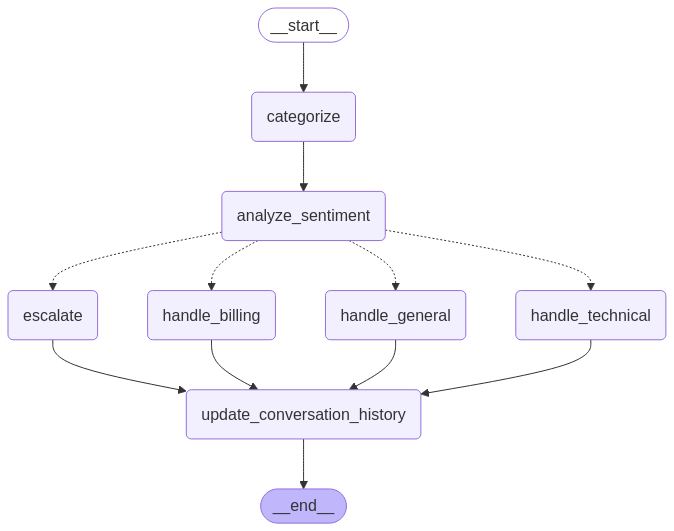

In [58]:
display(Image(app.get_graph().draw_mermaid_png()))

## Main Running Function

In [59]:
def is_exit_phrase(text):
    """Check if the text contains an exit phrase."""
    exit_phrases = ["thank you", "thanks", "exit", "quit", "bye", "goodbye"]
    return any(phrase in text.lower() for phrase in exit_phrases)

def process_query(query, conversation_history=None):
    """Process a single customer query through the LangGraph workflow."""
    if conversation_history is None:
        conversation_history = []
    
    # Initialize state
    state = {
        "query": query,
        "category": None,
        "sentiment": None,
        "response": None,
        "conversation_history": conversation_history
    }
    
    # Process the query
    try:
        result = app.invoke(state, config={"recursion_limit": 50})
        
        # Check if this was escalated to a human agent
        is_escalated = "escalated" in result.get("response", "").lower()
        
        return {
            "category": result.get("category", "Unknown"),
            "sentiment": result.get("sentiment", "Unknown"),
            "response": result.get("response", "I couldn't process your request."),
            "conversation_history": result.get("conversation_history", conversation_history),
            "should_exit": is_exit_phrase(query) or is_escalated
        }
    except Exception as e:
        print(f"Error processing query: {str(e)}")
        return {
            "category": "Error",
            "sentiment": "Neutral",
            "response": f"I'm sorry, but I encountered an error processing your request: {str(e)}",
            "conversation_history": conversation_history,
            "should_exit": False
        }

def interactive_customer_support():
    """Run the customer support agent interactively with human in the loop."""
    print("Welcome to Customer Support! Type 'exit' or 'thank you' to end the conversation.")
    print("Note: The conversation will also end if your query is escalated to a human agent.")
    
    # Initialize conversation history
    conversation_history = []
    
    while True:
        user_input = input("\nHow can I help you today? ")
        
        if not user_input.strip():
            print("I didn't catch that. Could you please repeat your question?")
            continue
        
        # Check for direct exit commands (this check is separate from the LangGraph processing)
        if is_exit_phrase(user_input):
            print("Thank you for contacting Customer Support. Have a great day!")
            break
        
        # Process the query
        result = process_query(user_input, conversation_history)
        
        # Update conversation history
        conversation_history = result.get("conversation_history", conversation_history)
        
        # Print the response
        print(f"\nAgent: {result.get('response')}")
        
        # Check if should exit based on thank you phrases or escalation
        if result.get("should_exit", False):
            # Check if this was due to escalation
            if "escalated" in result.get("response", "").lower():
                print("This conversation has been handed over to a human agent who will contact you shortly.")
            else:
                print("Thank you for contacting Customer Support. Have a great day!")
            break

In [60]:
interactive_customer_support()

Welcome to Customer Support! Type 'exit' or 'thank you' to end the conversation.
Note: The conversation will also end if your query is escalated to a human agent.

Agent: Hey there!  Thanks for reaching out.  How can I help you today?  To best assist you, could you please tell me a little more about what you need?  For example, are you experiencing a problem with a specific product or service?  Do you have a question about our company policies? Or are you looking for some general information?  The more details you can provide, the quicker I can help you resolve your issue.

Agent: Hey there!  Thanks for letting me know you're looking for your receipt.  To help me locate it for you, I'll need a little more information.  Could you please tell me:

* **The date of the purchase (approximate date is fine):** This will help narrow down the search.
* **The amount of the purchase (approximate amount is fine):**  This will further refine the search.
* **The email address associated with your ac